In [1]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_original_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_original_all_features_motor_vibration_x\features"
targetFolderSIZA = r"H:\Extracted_Features\SIZA\SIZA_original_all_features\features"
normalization_method = "z_score"

In [2]:
experiment_name = "best_features_time_freq"
project_name="best_features_time_freq",
run_name="best_features_time_freq"
domain="time-frequency"

In [3]:
binary_classification=True
plot_histograms_choice=False

# Environment Setup & Imports

In [4]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [5]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [6]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [7]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [8]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [9]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [10]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [11]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [12]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [13]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=False,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    domains_to_include=[domain]
)

Successfully loaded 161 files into a DataFrame with shape (200093, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected domains: ['time-frequency']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (200093, 9)


In [14]:
df_SIZA = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=False,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    domains_to_include=[domain]
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected domains: ['time-frequency']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 9)


In [15]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=False,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    domains_to_include=[domain]
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected domains: ['time-frequency']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 9)


In [16]:
combined_df = pd.concat([df_HBK, df_SIZA, df_MCC5], ignore_index=True)

In [17]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [18]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [19]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [20]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [21]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,7358
1,Target,Label
2,Target type,Binary
3,Target mapping,"damaged: 0, healthy: 1"
4,Original data shape,"(246359, 9)"
5,Transformed data shape,"(246359, 9)"
6,Transformed train set shape,"(172451, 9)"
7,Transformed test set shape,"(73908, 9)"
8,Numeric features,8
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

## Add aditional metrics

In [22]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [23]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001F97956F380>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001F97956F...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001F97956F...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [24]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [25]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.9371,0.9752,0.9371,0.9365,0.9353,0.8103,0.8142,0.8844,0.0629,0.7387,0.1538
1,0.9369,0.9777,0.9369,0.9364,0.9350,0.8089,0.8134,0.8825,0.0631,0.7367,0.1464
2,0.9364,0.9760,0.9364,0.9359,0.9345,0.8076,0.8120,0.8822,0.0636,0.7353,0.1508
3,0.9393,0.9770,0.9393,0.9388,0.9377,0.8173,0.8209,0.8886,0.0607,0.7473,0.1475
4,0.9335,0.9636,0.9335,0.9324,0.9319,0.8009,0.8036,0.8832,0.0665,0.7284,0.3744
5,0.9374,0.9765,0.9374,0.9369,0.9356,0.8107,0.8150,0.8837,0.0626,0.7389,0.1484
6,0.9385,0.9765,0.9385,0.9379,0.9367,0.8141,0.8182,0.8860,0.0615,0.7432,0.1497
7,0.9384,0.9763,0.9384,0.9378,0.9366,0.8138,0.8178,0.8859,0.0616,0.7429,0.1493
8,0.9358,0.9761,0.9358,0.9353,0.9338,0.8054,0.8099,0.8804,0.0642,0.7324,0.1501


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/04 14:28:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [26]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [27]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,varWavelet,1886
1,entropyWavelet,1731
2,meanSpectrogram,1360
3,meanWavelet,1262
4,varSpectrogram,1246
5,energySpectrogram,1028
6,energyWavelet,805
7,entropySpectrogram,706


In [28]:
add_top_features(lightgbm_top_features, top_n=3)

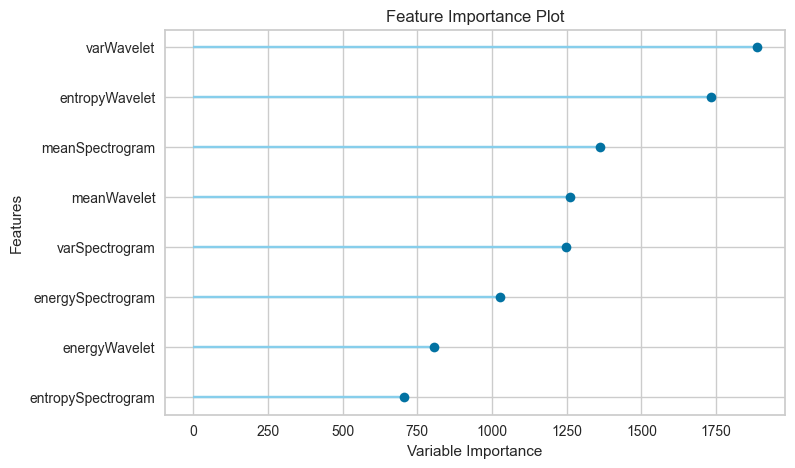

In [29]:
plot_model(lightgbm, plot='feature')

In [30]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.9392,0.9775,0.9392,0.9388,0.9373,0.8159,0.8203,0.8861,0.0608,0.7452,0.1457


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [31]:
predictions_lightgbm

,varSpectrogram,meanWavelet,meanSpectrogram,energySpectrogram,entropyWavelet,energyWavelet,entropySpectrogram,varWavelet,Label,prediction_label,prediction_score
93960,-0.119511,-0.548131,-0.239607,-0.119636,0.169895,-0.299386,-0.156178,-0.275192,damaged,damaged,1.0000
371,-0.119511,-0.715625,-0.242149,-0.119637,0.164535,-0.302669,-0.156183,-0.276436,healthy,damaged,0.8250
33266,-0.119511,-0.726618,-0.242150,-0.119637,0.164418,-0.302703,-0.156183,-0.276412,healthy,healthy,0.9987
238774,-0.119454,-0.078935,-0.198761,-0.119575,0.202637,-0.225960,-0.155680,-0.210708,damaged,damaged,0.7908
210317,-0.119508,-0.522627,-0.236005,-0.119633,0.174123,-0.291462,-0.156153,-0.266166,damaged,damaged,0.9831
...,...,...,...,...,...,...,...,...,...,...,...
241132,-0.119505,-0.530413,-0.234696,-0.119630,0.173715,-0.290368,-0.156126,-0.264591,damaged,damaged,0.9525
214791,-0.119501,-0.481127,-0.232590,-0.119626,0.175848,-0.287531,-0.156096,-0.262673,damaged,damaged,0.9925
165165,-0.119394,0.267979,-0.141534,-0.119492,0.193819,-0.113117,-0.155000,-0.108072,damaged,damaged,0.9997
217690,-0.118854,0.351942,-0.121442,-0.118953,0.204984,-0.101980,-0.151695,-0.105311,damaged,damaged,0.5022


In [32]:
get_incorrect_predictions(predictions_lightgbm)

,varSpectrogram,meanWavelet,meanSpectrogram,energySpectrogram,entropyWavelet,energyWavelet,entropySpectrogram,varWavelet,Label,prediction_label,prediction_score
371,-0.119511,-0.715625,-0.242149,-0.119637,0.164535,-0.302669,-0.156183,-0.276436,healthy,damaged,0.8250
16,-0.119511,-0.718577,-0.242153,-0.119637,0.164459,-0.302711,-0.156183,-0.276468,healthy,damaged,0.5461
258524,-0.119511,-0.734626,-0.242255,-0.119637,0.164046,-0.302923,-0.156183,-0.276646,healthy,damaged,0.5160
207745,-0.119248,-0.053889,-0.181161,-0.119369,0.195415,-0.197872,-0.154350,-0.178280,healthy,damaged,0.9997
255723,-0.119463,-0.162859,-0.205668,-0.119586,0.196681,-0.240971,-0.155770,-0.222601,healthy,damaged,0.7214
...,...,...,...,...,...,...,...,...,...,...,...
200497,-0.119501,-0.491867,-0.231184,-0.119626,0.176503,-0.284612,-0.156092,-0.258714,healthy,damaged,0.5836
260610,-0.119423,-0.069341,-0.194898,-0.119544,0.201230,-0.220567,-0.155466,-0.204878,healthy,damaged,0.6701
258687,-0.119503,-0.523616,-0.233108,-0.119628,0.174837,-0.288400,-0.156112,-0.262370,healthy,damaged,0.6932
205706,-0.119506,-0.516059,-0.234408,-0.119632,0.174827,-0.290323,-0.156138,-0.264963,healthy,damaged,0.9231


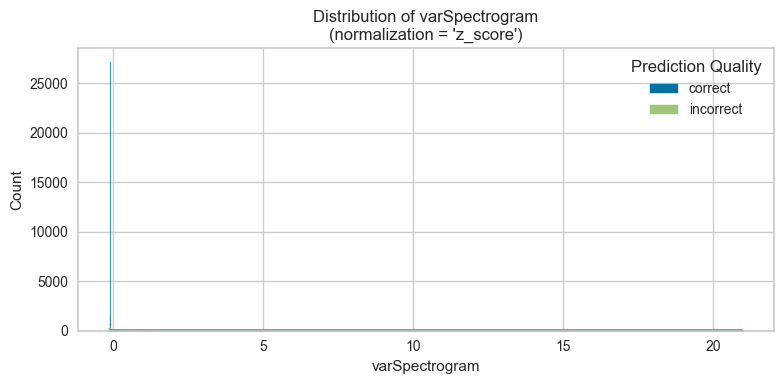

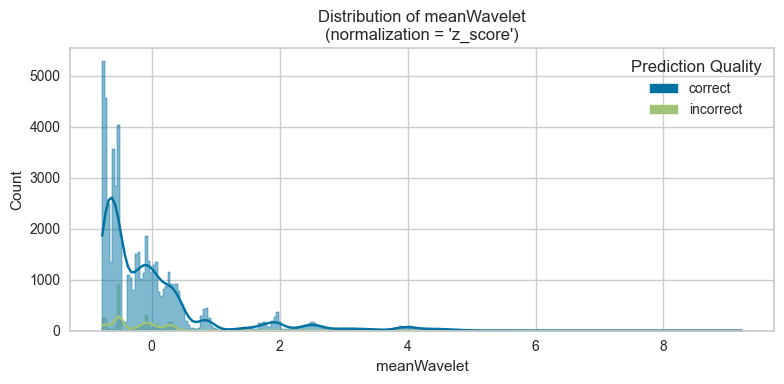

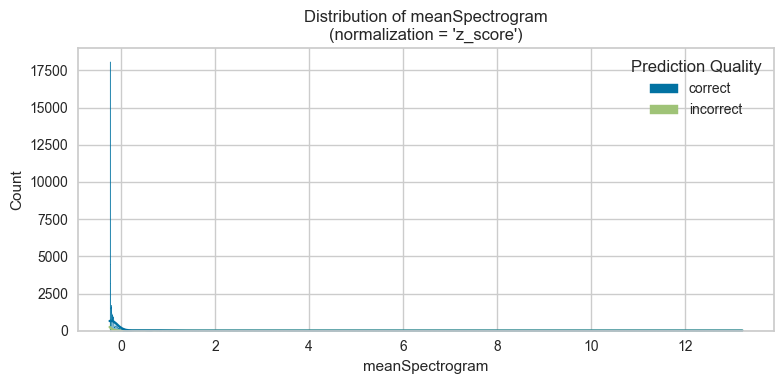

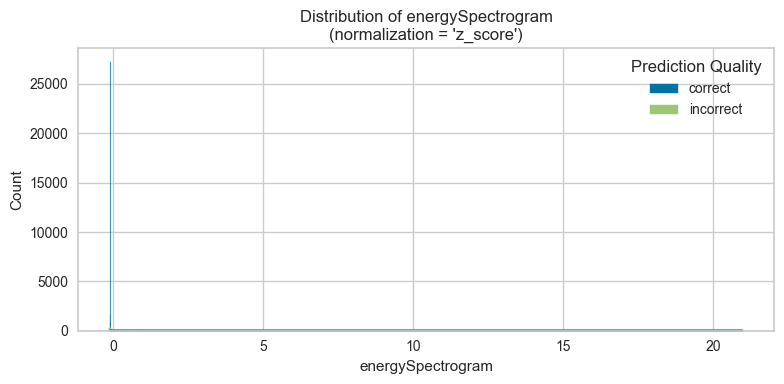

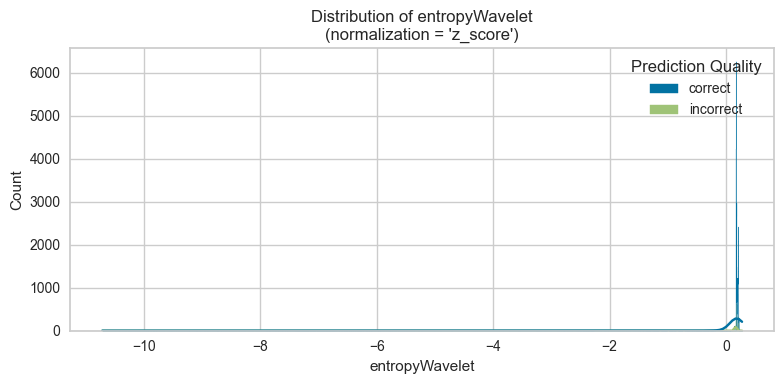

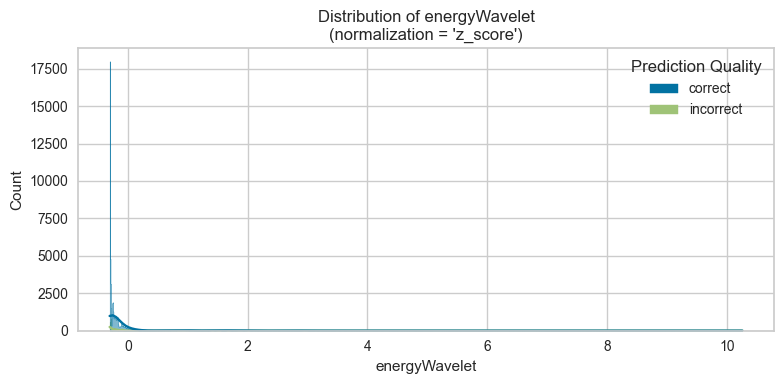

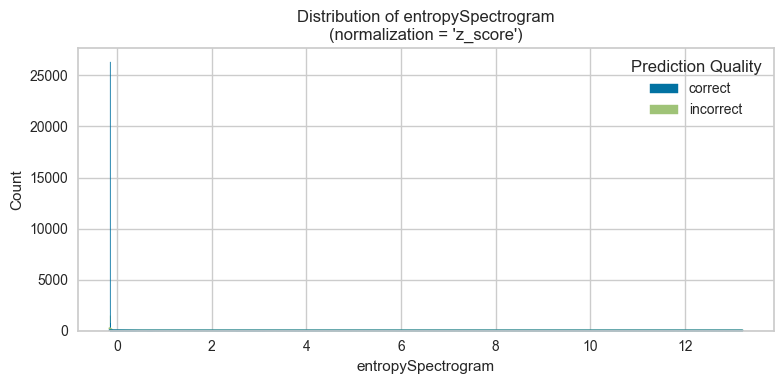

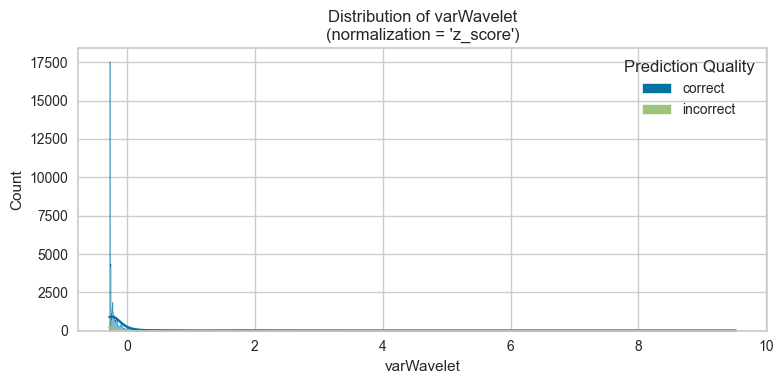

In [33]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [34]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [35]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [36]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [37]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,meanWavelet,0.238915
1,meanSpectrogram,0.176950
2,energyWavelet,0.168983
3,varWavelet,0.164402
4,entropyWavelet,0.134021
5,entropySpectrogram,0.053770
6,energySpectrogram,0.033713
7,varSpectrogram,0.029247


In [38]:
add_top_features(rf_top_features, top_n=3)

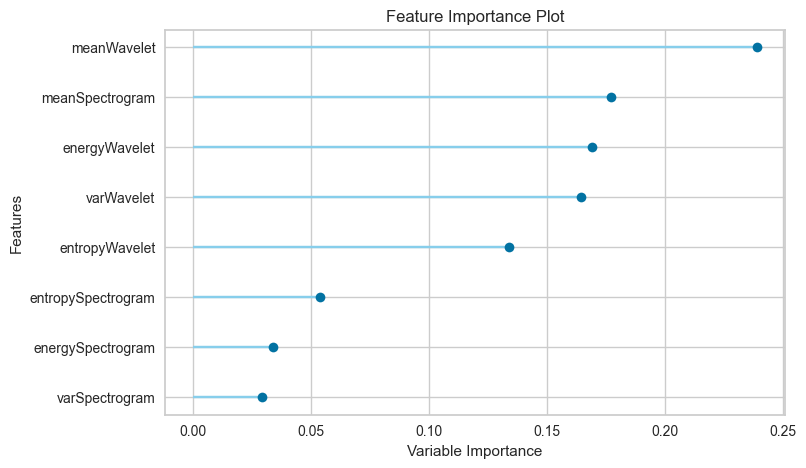

In [39]:
plot_model(rf, plot='feature')

In [40]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9681,0.9897,0.9681,0.9680,0.9677,0.9063,0.9074,0.9414,0.0319,0.8632,0.1128


In [41]:
get_incorrect_predictions(predictions_rf)

,varSpectrogram,meanWavelet,meanSpectrogram,energySpectrogram,entropyWavelet,energyWavelet,entropySpectrogram,varWavelet,Label,prediction_label,prediction_score
371,-0.119511,-0.715625,-0.242149,-0.119637,0.164535,-0.302669,-0.156183,-0.276436,healthy,damaged,0.7738
207745,-0.119248,-0.053889,-0.181161,-0.119369,0.195415,-0.197872,-0.154350,-0.178280,healthy,damaged,0.9300
255723,-0.119463,-0.162859,-0.205668,-0.119586,0.196681,-0.240971,-0.155770,-0.222601,healthy,damaged,0.5600
207040,-0.119401,0.005402,-0.184564,-0.119519,0.206877,-0.207824,-0.155277,-0.195858,healthy,damaged,0.9800
208936,-0.118877,0.296737,-0.130668,-0.118982,0.200995,-0.114825,-0.151885,-0.113825,healthy,damaged,0.7200
...,...,...,...,...,...,...,...,...,...,...,...
210944,-0.119449,-0.104866,-0.197481,-0.119570,0.201810,-0.230640,-0.155639,-0.214343,damaged,healthy,0.5700
203710,-0.119334,0.121655,-0.173694,-0.119450,0.209357,-0.187887,-0.154807,-0.183022,healthy,damaged,0.6200
206916,-0.119441,-0.109464,-0.198674,-0.119563,0.200570,-0.232714,-0.155599,-0.216526,healthy,damaged,0.7200
215108,-0.119511,-0.664994,-0.241515,-0.119637,0.166263,-0.301561,-0.156183,-0.275560,damaged,healthy,0.7361


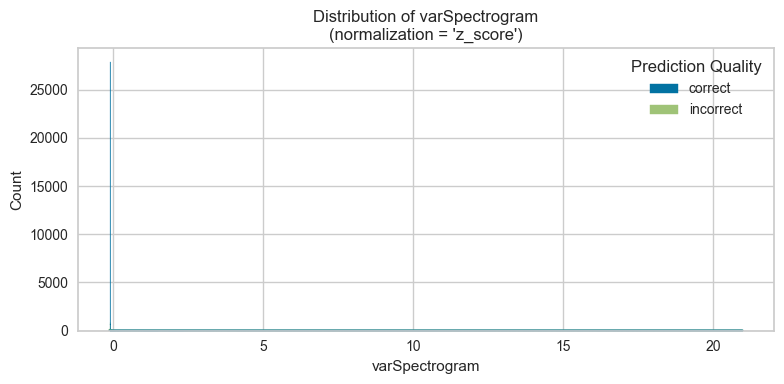

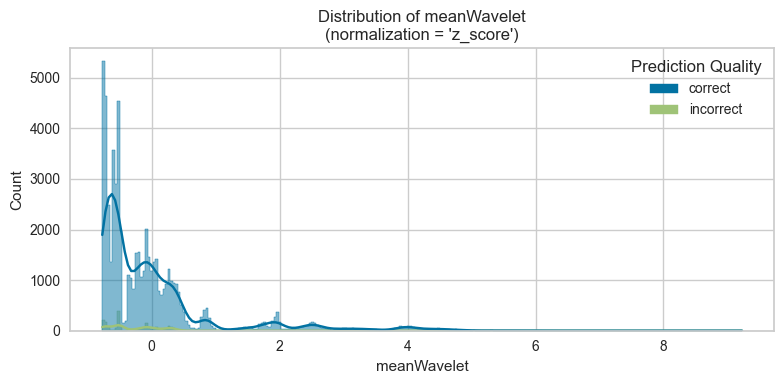

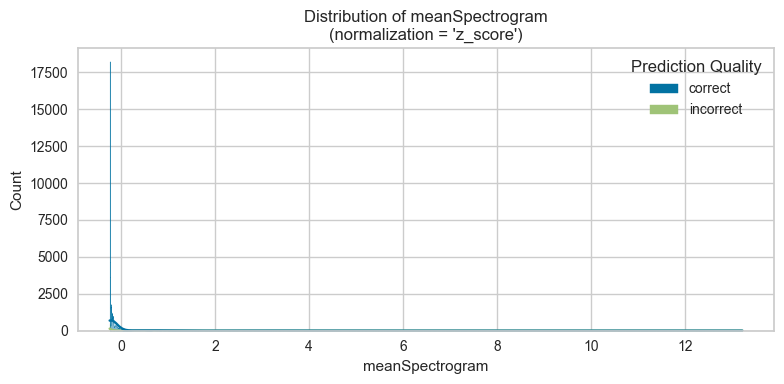

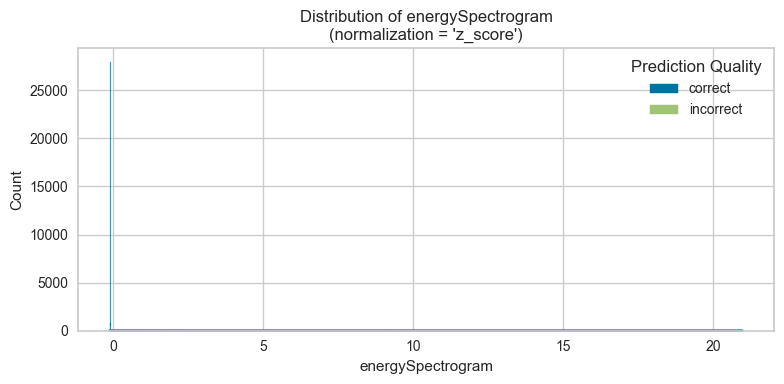

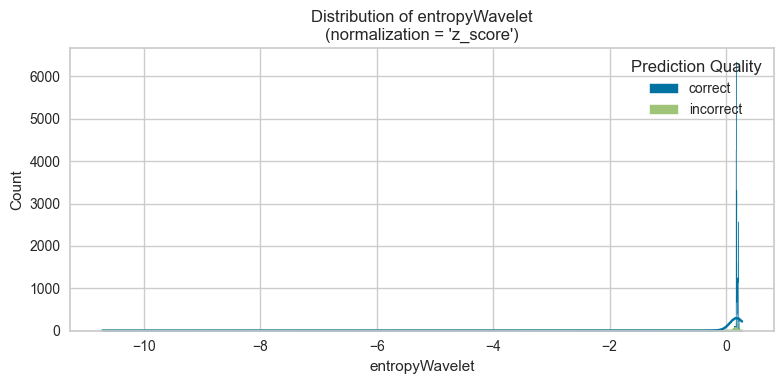

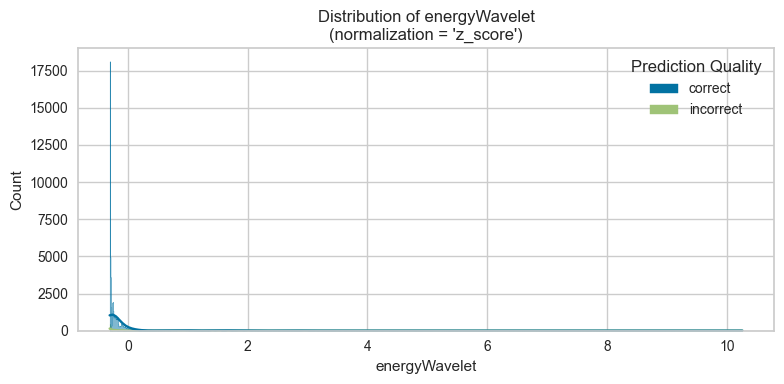

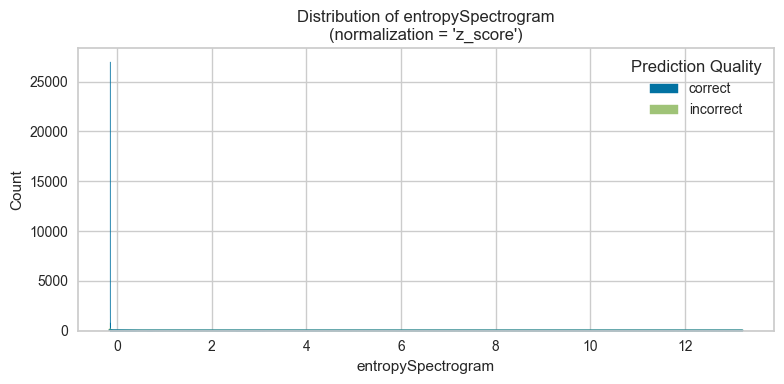

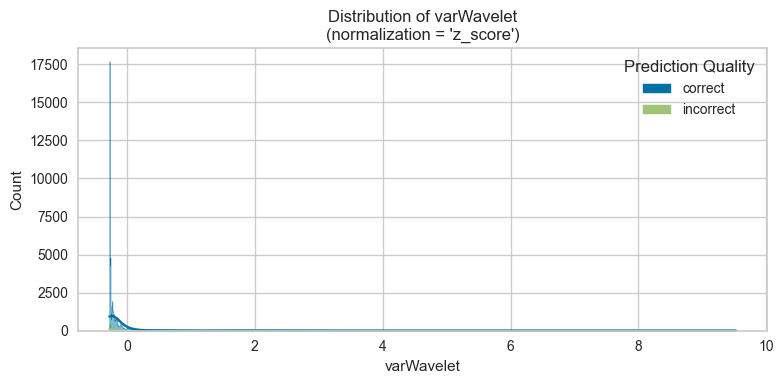

In [42]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [43]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [44]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [45]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [46]:
svm_top_features = get_svm_feature_importance_df(svm, features_df_training_normalized)
svm_top_features

,Features,importance
0,entropyWavelet,92.970322
1,energyWavelet,39.868439
2,entropySpectrogram,17.448406
3,meanWavelet,15.263413
4,meanSpectrogram,10.409186
5,varWavelet,8.965716
6,energySpectrogram,4.367490
7,varSpectrogram,4.326579


In [47]:
add_top_features(svm_top_features, top_n=3)

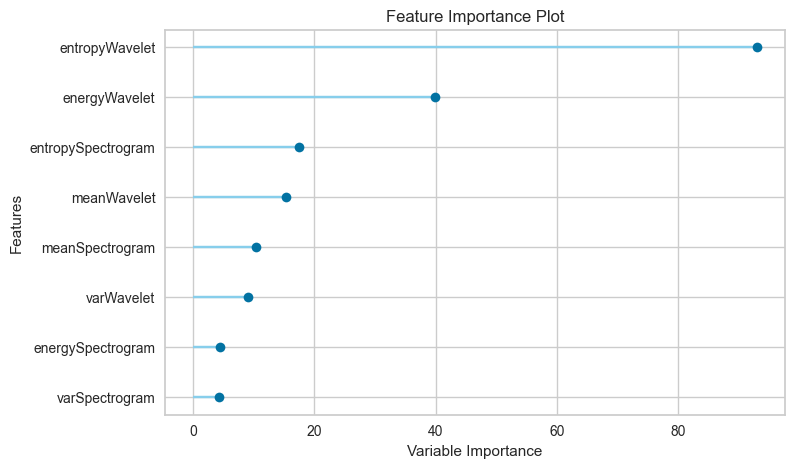

In [48]:
plot_model(svm, plot='feature')

In [49]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.8503,0,0.8503,0.8433,0.8451,0.5436,0.5474,0.7553,0.1497,0.4672,0


In [50]:
get_incorrect_predictions(predictions_svm)

,varSpectrogram,meanWavelet,meanSpectrogram,energySpectrogram,entropyWavelet,energyWavelet,entropySpectrogram,varWavelet,Label,prediction_label
261113,-0.119359,0.075207,-0.174411,-0.119475,0.209378,-0.191124,-0.154960,-0.182138,healthy,damaged
207745,-0.119248,-0.053889,-0.181161,-0.119369,0.195415,-0.197872,-0.154350,-0.178280,healthy,damaged
255723,-0.119463,-0.162859,-0.205668,-0.119586,0.196681,-0.240971,-0.155770,-0.222601,healthy,damaged
207040,-0.119401,0.005402,-0.184564,-0.119519,0.206877,-0.207824,-0.155277,-0.195858,healthy,damaged
254381,-0.119498,-0.508877,-0.232647,-0.119624,0.175432,-0.286011,-0.156080,-0.259882,healthy,damaged
...,...,...,...,...,...,...,...,...,...,...
6607,-0.119510,-0.604374,-0.238855,-0.119636,0.170918,-0.296466,-0.156173,-0.270283,healthy,damaged
19837,-0.119511,-0.621616,-0.239581,-0.119636,0.169476,-0.297950,-0.156176,-0.271782,healthy,damaged
100049,-0.119511,-0.752595,-0.242343,-0.119637,0.163765,-0.303049,-0.156183,-0.276743,damaged,healthy
205706,-0.119506,-0.516059,-0.234408,-0.119632,0.174827,-0.290323,-0.156138,-0.264963,healthy,damaged


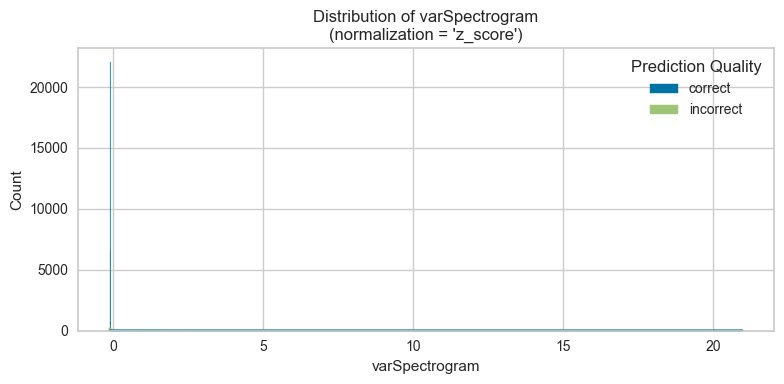

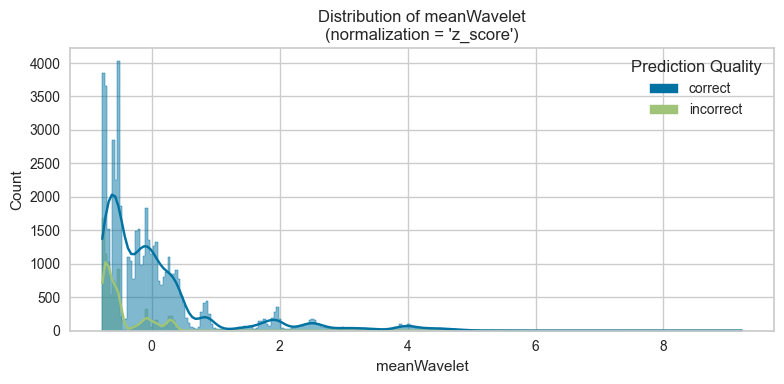

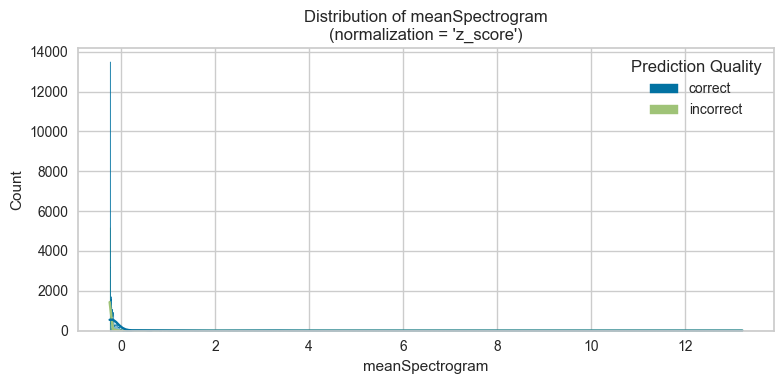

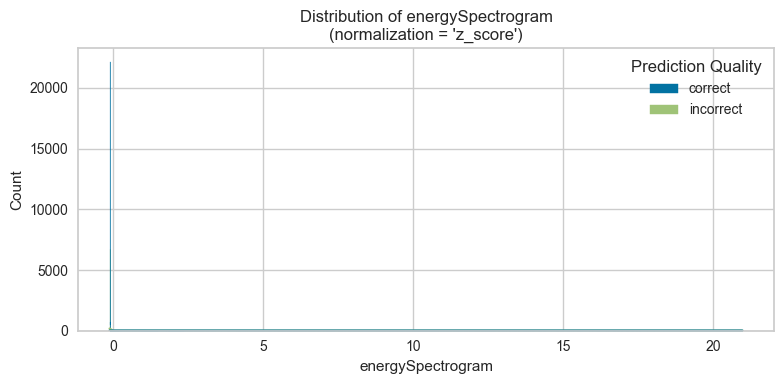

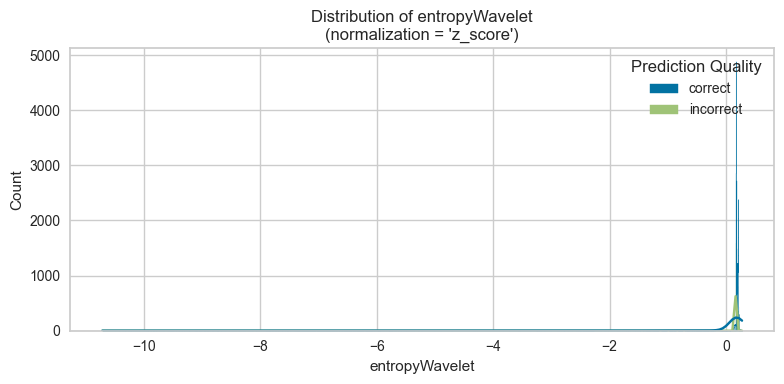

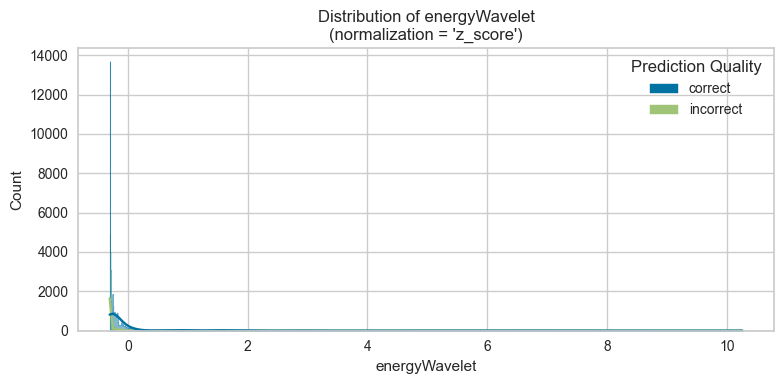

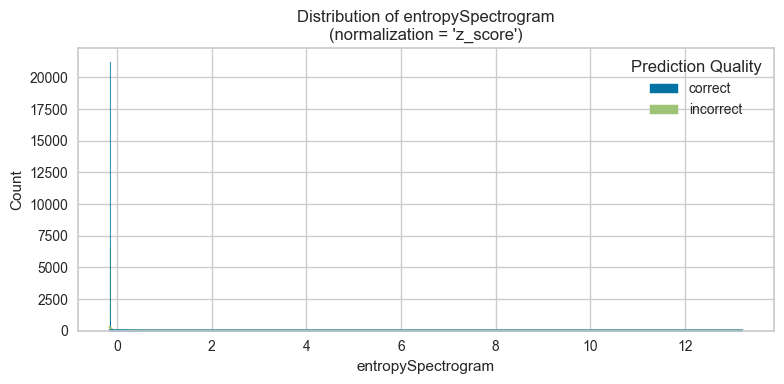

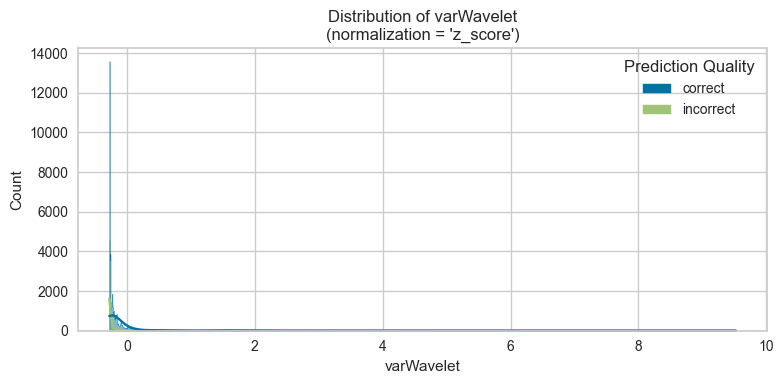

In [51]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [52]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (197087, 9) | Val Shape: (49272, 9) | Test Shape: (61590, 9)


In [53]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [54]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['varSpectrogram', 'meanWavelet', 'meanSpectrogram', 'energySpectrogram', 'entropyWavelet', 'energyWavelet', 'entropySpectrogram', 'varWavelet']


In [55]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [56]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [57]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=20,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [58]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [59]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-04 14:31:13,780 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [60]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-04 14:31:13,841 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-04 14:31:13,866 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-04 14:31:13,966 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-04 14:31:14,014 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-04 14:31:14,061 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  119 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 119 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 119 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

2025-10-04 14:35:15,909 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-04 14:35:15,909 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [61]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8315635919570923     │
│        test_auroc         │    0.8550439476966858     │
│     test_cohen_kappa      │    0.4222906827926636     │
│       test_f1_score       │    0.8315635919570923     │
│   test_hamming_distance   │    0.1684364378452301     │
│    test_jaccard_index     │    0.5811874866485596     │
│         test_loss         │    0.38960349559783936    │
│        test_loss_0        │    0.38960349559783936    │
│  test_matthews_corrcoef   │    0.45260581374168396    │
│      test_precision       │    0.8315635919570923     │
│        test_recall        │    0.8315635919570923     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [62]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [63]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-04 14:35:33,104 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [64]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-04 14:35:33,148 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-04 14:35:33,174 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-04 14:35:33,271 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-04 14:35:33,320 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-04 14:35:33,351 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.3 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     20 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.3 K                                                                                            
Non-trainable params: 8                                                                                            
Total params: 3.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


2025-10-04 14:53:25,997 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-04 14:53:25,997 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [65]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_damaged_probability,Label_healthy_probability,Label_prediction
93960,0.672618,0.327382,damaged
371,0.564676,0.435324,damaged
33266,0.557273,0.442727,damaged
238774,0.879360,0.120640,damaged
210317,0.689966,0.310034,damaged
16,0.562675,0.437325,damaged
117119,0.771328,0.228672,damaged
258524,0.551756,0.448244,damaged
226017,0.908167,0.091833,damaged
6208,0.550560,0.449440,damaged


In [66]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.774573802947998     │
│        test_auroc         │    0.8295356035232544     │
│     test_cohen_kappa      │   -6.42766899545677e-05   │
│       test_f1_score       │     0.774573802947998     │
│   test_hamming_distance   │    0.22542621195316315    │
│    test_jaccard_index     │     0.387286901473999     │
│         test_loss         │    0.42403116822242737    │
│        test_loss_0        │    0.42403116822242737    │
│  test_matthews_corrcoef   │    0.0818861871957779     │
│      test_precision       │     0.774573802947998     │
│        test_recall        │     0.774573802947998     │
└───────────────────────────┴───────────────────────────┘

In [67]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
0,varSpectrogram,1.614077
7,varWavelet,1.364841
6,entropySpectrogram,1.065850
3,energySpectrogram,0.986583
1,meanWavelet,0.973297
2,meanSpectrogram,0.772762
4,entropyWavelet,0.708845
5,energyWavelet,0.513746


In [68]:
add_top_features(gandalf_top_features, top_n=3)

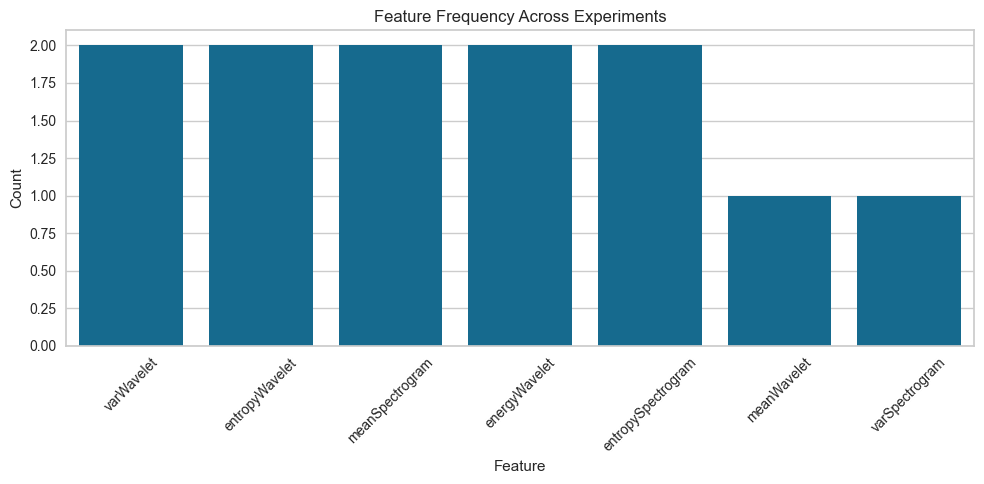

In [69]:
plot_feature_importance()